# <ins>Apartment Price Machine Learning</ins>
By: Liam H, Noah W, Jay C, Sameer I

In this project, we will be developing a pipeline to assess the value of an apartment based on a specific set of features. This dataset can be found from the kaggle website through the following link: https://www.kaggle.com/datasets/mrdaniilak/russia-real-estate-20182021

We will be using a linear regression model to assess the accuracy of our pipeline (using r-squared values)

<b>Step 1:</b> *Import required packages*

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

<b>Step 2:</b> *Load .csv file as a dataframe*

In [2]:
DATA = pd.read_csv(r'C:\Users\Lhaye\OneDrive\Documents\Russian_Real_Estate info.csv')
DATA

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5477001,19739760,2021-05-01,20:13:58,55.804736,37.750898,3,1,8,17,4,93.2,13.8,11
5477002,12503160,2021-05-01,20:14:01,55.841415,37.489624,3,2,17,32,2,45.9,6.6,11
5477003,8800000,2021-05-01,20:14:04,56.283909,44.075408,2871,2,4,17,3,86.5,11.8,1
5477004,11831910,2021-05-01,20:14:12,55.804736,37.750898,3,1,8,33,2,52.1,18.9,11


<u><b>Feature Definitions</b></u> - From Kaggle website

- date - date of publication of the announcement;
- time - the time when the ad was published;
- geo_lat - Latitude
- geo_lon - Longitude
- region - Region of Russia. There are 85 subjects in the country in total.
- building_type - Facade type. 0 - Other. 1 - Panel. 2 - Monolithic. 3 - Brick. 4 - Blocky. 5 - Wooden
- object_type - Apartment type. 1 - Secondary real estate market; 2 - New building;
- level - Apartment floor
- levels - Number of storeys
- rooms - the number of living rooms. If the value is "-1", then it means "studio apartment"
- area - the total area of ​​the apartment
- kitchen_area - Kitchen area
- price - Price. in rubles

<b>Step 3:</b> *Inflation Isolation and similar asset type selection*

<u>Inflation Isolation:</u>

In order to accurately predict asset values based exclusively on their respective features, it is important for us to remove any alterations to the valuation from general appreciation in housing demand. In order to do this we will do the following steps...
1. Select a dataframe from only date and price columns
2. Group data based on month
3. Find average of each month grouping
4. Calculate percentage change from each month
5. Find cumulative percentage change for each month
6. Merge this information back with main DATA dataframe and divide listed price by respective cumulative gross adjustment

<u>Similar asset type selection:</u>

We will be using apartments from the same region (2661) and same object type (1) to help isolate for any other 'variables' not listed in the dataset.

In [3]:
#Isolate for only object type 1 (apartment style estates) & same region (2661)
DATA = DATA.loc[DATA['object_type'] == 1]
DATA = DATA.loc[DATA['region'] == 2661]

DATASAMPLE = DATA.iloc[0:120000,:] #select a sample of the dataset (for and covid isolation) - end of dataset approximately end of 2019

#Infl. Iso FULL
InflCalc = DATA.iloc[:,0:2] # select only price and date
InflCalc['date'] = pd.to_datetime(InflCalc['date'], errors='coerce') #convert to datetime like value
InflCalc['Month'] = InflCalc['date'].dt.to_period('M') #insert new column 'Month' with only year and month (for grouping)

Series = InflCalc.groupby('Month')['price'].mean() #create series with average price per month

PCT_Change = Series.pct_change() #percentage change per month

#cumulative % to be used for comparison between base month and all other months
PCT_Change = PCT_Change.cumsum()
PCT_Change.rename("PCT_CHNG",inplace = True)

#same process as with InflCalc DF (for merging)
DATA['date'] = pd.to_datetime(DATA['date'], errors='coerce')
DATA['Month'] = DATA['date'].dt.to_period('M') 

DATA = DATA.merge(PCT_Change,how='left',left_on='Month',right_index=True) #merge

DATA['ADJ_Price'] = (DATA['price'])/((DATA['PCT_CHNG'])+1) #calculate adjusted price

#Fill in null values
DATA['ADJ_Price'].fillna(DATA['price'],inplace = True)
DATA['PCT_CHNG'].fillna(1,inplace=True)
DATA

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,Month,PCT_CHNG,ADJ_Price
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1,2018-02,1.000000,6.050000e+06
7,3600000,2018-03-04,20:52:38,59.875526,30.395457,2661,1,2,5,1,31.1,6.0,1,2018-03,-0.404959,6.050000e+06
36,3200000,2018-04-10,16:10:12,59.827465,30.201827,2661,1,7,9,1,31.0,7.0,1,2018-04,0.076523,2.972533e+06
47,6500000,2018-04-23,11:47:58,59.988334,29.786928,2661,3,3,3,3,89.0,10.0,1,2018-04,0.076523,6.037958e+06
54,6300000,2018-04-28,17:47:24,59.911622,30.284556,2661,3,5,5,2,99.9,14.5,1,2018-04,0.076523,5.852175e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5476909,8000000,2021-05-01,19:56:37,59.951248,30.492657,2661,1,5,9,3,60.0,6.2,1,2021-05,1.398666,3.335187e+06
5476937,12500000,2021-05-01,20:02:37,59.853716,30.396701,2661,1,1,9,3,67.0,6.0,1,2021-05,1.398666,5.211230e+06
5476949,30000000,2021-05-01,20:04:42,59.961501,30.255689,2661,2,4,8,2,92.0,21.6,1,2021-05,1.398666,1.250695e+07
5476964,9600000,2021-05-01,20:08:40,59.907618,30.322752,2661,3,3,6,3,62.0,8.6,1,2021-05,1.398666,4.002225e+06


In [4]:
#Infl. Iso SAMPLE
InflCalcSAMPLE = DATASAMPLE.iloc[:,0:2] # select only price and date
InflCalcSAMPLE['date'] = pd.to_datetime(InflCalcSAMPLE['date'], errors='coerce') #convert to datetime like value
InflCalcSAMPLE['Month'] = InflCalcSAMPLE['date'].dt.to_period('M') #insert new column 'Month' with only year and month (for grouping)

SeriesSAMPLE = InflCalcSAMPLE.groupby('Month')['price'].mean() #create series with average price per month

PCT_ChangeSAMPLE = SeriesSAMPLE.pct_change() #percentage change per month

#cumulative % to be used for comparison between base month and all other months
PCT_ChangeSAMPLE = PCT_ChangeSAMPLE.cumsum()
PCT_ChangeSAMPLE.rename("PCT_CHNG",inplace = True)

#same process as with InflCalc DF (for merging)
DATASAMPLE['date'] = pd.to_datetime(DATASAMPLE['date'], errors='coerce')
DATASAMPLE['Month'] = DATASAMPLE['date'].dt.to_period('M') 

DATASAMPLE = DATASAMPLE.merge(PCT_ChangeSAMPLE,how='left',left_on='Month',right_index=True) #merge

DATASAMPLE['ADJ_Price'] = (DATASAMPLE['price'])/((DATASAMPLE['PCT_CHNG'])+1) #calculate adjusted price

#Fill in null values
DATASAMPLE['ADJ_Price'].fillna(DATASAMPLE['price'],inplace = True)
DATASAMPLE['PCT_CHNG'].fillna(1,inplace=True)
DATASAMPLE

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,Month,PCT_CHNG,ADJ_Price
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1,2018-02,1.000000,6.050000e+06
7,3600000,2018-03-04,20:52:38,59.875526,30.395457,2661,1,2,5,1,31.1,6.0,1,2018-03,-0.404959,6.050000e+06
36,3200000,2018-04-10,16:10:12,59.827465,30.201827,2661,1,7,9,1,31.0,7.0,1,2018-04,0.076523,2.972533e+06
47,6500000,2018-04-23,11:47:58,59.988334,29.786928,2661,3,3,3,3,89.0,10.0,1,2018-04,0.076523,6.037958e+06
54,6300000,2018-04-28,17:47:24,59.911622,30.284556,2661,3,5,5,2,99.9,14.5,1,2018-04,0.076523,5.852175e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899596,6550000,2019-11-18,16:25:25,59.975990,30.386745,2661,2,9,16,2,57.5,11.4,1,2019-11,1.478193,2.643055e+06
2899597,4300000,2019-11-18,16:25:33,59.841938,30.113185,2661,2,8,16,1,32.4,9.3,1,2019-11,1.478193,1.735135e+06
2899604,6800000,2019-11-18,16:27:11,60.029022,30.250049,2661,2,15,24,2,53.0,9.0,1,2019-11,1.478193,2.743935e+06
2899649,4770000,2019-11-18,16:34:45,59.975990,30.386745,2661,2,11,16,1,39.7,11.5,1,2019-11,1.478193,1.924789e+06


<b>Step 4:</b> *Check if any null values remain*

In [5]:
CountFULL = DATA.isnull().sum(axis=0).sum()
CountSAMPLE = DATA.isnull().sum(axis=0).sum()
print(CountFULL)
print(CountSAMPLE)

0
0


in our case no nulls - if there were nulls additional steps would be needed to transform null values

<b>Step 5:</b> *Seperate values into X and Y (dependent and independents) then train test split*

In [6]:
#Seperate values into X and Y FULL
Xf = DATA.iloc[:,3:12]
Yf = DATA.iloc[:,15]

Xf_train,Xf_test,Yf_train,Yf_test = train_test_split(Xf,Yf,test_size = 0.3,random_state = 100)

#Seperate values into X and Y SAMPLE
Xs = DATASAMPLE.iloc[:,3:12]
Ys = DATASAMPLE.iloc[:,15]

Xs_train,Xs_test,Ys_train,Ys_test = train_test_split(Xs,Ys,test_size = 0.3,random_state = 100)

<b>Step 6:</b> *Pre-processing*

Null adjustment not needed as no null values exist in data (only standardization needed) - found above

In [7]:
#numerical x values

#Step 1A    
from sklearn.preprocessing import StandardScaler

numX_trans = Pipeline(
    [
        ('1A',StandardScaler())
    ])


#categorical x values

#Step 1B
from sklearn.preprocessing import OneHotEncoder

catX_trans = Pipeline(
    [
        ('1B',OneHotEncoder())
    ])

<b>Step 7:</b> *Sort between numerical and categorical X values for application of preprocessing steps*

In [8]:
from sklearn.compose import ColumnTransformer
numX = ['geo_lat','geo_lon','level','levels','rooms','area','kitchen_area']
catX = ['building_type']

#application on numX and catX
#Step 1C
full_trans = ColumnTransformer (
    [
        ('1C_i',numX_trans,numX),
        ('1C_ii',catX_trans,catX)
    ])

<b>Step 8:</b> *Set up training environment*

In [9]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

Here we will test to see which n_components value yields us the largest R Squared

In [10]:
#full
i=2
LISTf = pd.Series([])
while i <=11:
    TrainLRf = Pipeline(
        [
            ('1Cf',full_trans),
            ('2_PCAf',PCA(n_components = i)),
            ('2_LRf',LinearRegression())
        ])

    TrainLRf.fit(Xf_train,Yf_train)
    Seriesf = pd.Series(TrainLRf.score(Xf_test,Yf_test),index=[i])
    LISTf = LISTf.append(Seriesf)
    i += 1
I_Bestf = LISTf[LISTf == LISTf.max()].index[0] # find n_componenets value that gives max score result
print('The maximum accuracy is:',LISTf[I_Bestf], ' with n_componenets =',I_Bestf)
LISTf

<ipython-input-10-b8bfd291836f>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  LISTf = pd.Series([])


The maximum accuracy is: 0.15341972801690873  with n_componenets = 11


2     0.147236
3     0.147457
4     0.147225
5     0.144897
6     0.150370
7     0.150526
8     0.150059
9     0.151132
10    0.153051
11    0.153420
dtype: float64

In [11]:
#sample
i=2
LISTs = pd.Series([])
while i <=11:
    TrainLRs = Pipeline(
        [
            ('1Cs',full_trans),
            ('2_PCAs',PCA(n_components = i)),
            ('2_LRs',LinearRegression())
        ])

    TrainLRs.fit(Xs_train,Ys_train)
    Seriess = pd.Series(TrainLRs.score(Xs_test,Ys_test),index=[i])
    LISTs = LISTs.append(Seriess)
    i += 1
I_Bests = LISTs[LISTs == LISTs.max()].index[0] # find n_componenets value that gives max score result
print('The maximum accuracy is:',LISTs[I_Bests], ' with n_componenets =',I_Bests)
LISTs


<ipython-input-11-1ea777162b32>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  LISTs = pd.Series([])


The maximum accuracy is: 0.5258441186311429  with n_componenets = 11


2     0.425631
3     0.425867
4     0.427378
5     0.443865
6     0.449320
7     0.450411
8     0.525828
9     0.525763
10    0.525769
11    0.525844
dtype: float64

<b>Step 9:</b> *Use the best n_components value to run the linear regression pipeline*

In [12]:
TrainLRFULL = Pipeline(
        [
            ('1CF',full_trans),
            ('2_PCAF',PCA(n_components = I_Bestf)),
            ('2_LRF',LinearRegression())
        ])

TrainLRFULL.fit(Xf_train,Yf_train)

Pipeline(steps=[('1CF',
                 ColumnTransformer(transformers=[('1C_i',
                                                  Pipeline(steps=[('1A',
                                                                   StandardScaler())]),
                                                  ['geo_lat', 'geo_lon',
                                                   'level', 'levels', 'rooms',
                                                   'area', 'kitchen_area']),
                                                 ('1C_ii',
                                                  Pipeline(steps=[('1B',
                                                                   OneHotEncoder())]),
                                                  ['building_type'])])),
                ('2_PCAF', PCA(n_components=11)),
                ('2_LRF', LinearRegression())])

In [13]:
TrainLRSAMPLE = Pipeline(
        [
            ('1CS',full_trans),
            ('2_PCAS',PCA(n_components = I_Bests)),
            ('2_LRS',LinearRegression())
        ])

TrainLRSAMPLE.fit(Xs_train,Ys_train)

Pipeline(steps=[('1CS',
                 ColumnTransformer(transformers=[('1C_i',
                                                  Pipeline(steps=[('1A',
                                                                   StandardScaler())]),
                                                  ['geo_lat', 'geo_lon',
                                                   'level', 'levels', 'rooms',
                                                   'area', 'kitchen_area']),
                                                 ('1C_ii',
                                                  Pipeline(steps=[('1B',
                                                                   OneHotEncoder())]),
                                                  ['building_type'])])),
                ('2_PCAS', PCA(n_components=11)),
                ('2_LRS', LinearRegression())])

<b>Step 10:</b> *Results*

In [14]:
print('Linear Regression accuracy - FULL',TrainLRFULL.score(Xf_test,Yf_test))
print('Linear Regression accuracy - SAMPLE',TrainLRSAMPLE.score(Xs_test,Ys_test))

Linear Regression accuracy - FULL 0.1435683866506826
Linear Regression accuracy - SAMPLE 0.5258441186311429


## Additional Analysis

Comparative scores over n_components


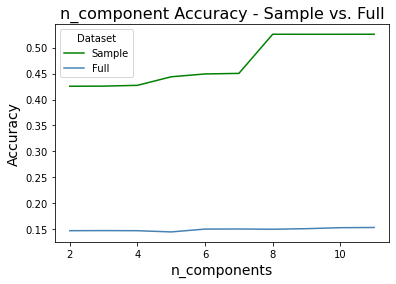

In [15]:
# n_component maximization
import matplotlib.pyplot as plt
plt.plot(LISTs, label='Sample', color='green')
plt.plot(LISTf, label='Full', color='steelblue')
plt.legend(title='Dataset')
plt.ylabel('Accuracy',fontsize = 14)
plt.xlabel('n_components', fontsize = 14)
plt.title('n_component Accuracy - Sample vs. Full', fontsize = 16)
plt.show()

Unadjusted price over time with sample data

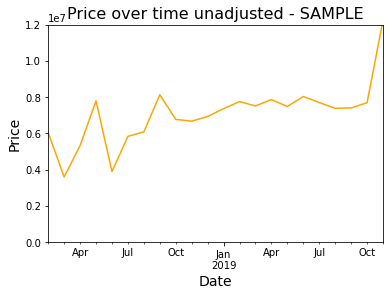

In [16]:
#shows average price over time SAMPLE
SeriesSAMPLE.plot(color = 'orange')
plt.ylabel('Price',fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.title('Price over time unadjusted - SAMPLE', fontsize = 16)
plt.ylim(0, 12000000)
plt.show()

Adjusted price over time with sample data

<ipython-input-17-1c8ae99150d4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ADJPRCSMPL['Month'] = ADJPRCSMPL['date'].dt.to_period('M')


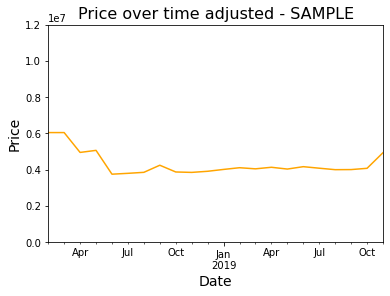

In [17]:
#average price over time sample - ADJUSTED
ADJPRCSMPL = DATASAMPLE[["ADJ_Price","date"]] 
ADJPRCSMPL['Month'] = ADJPRCSMPL['date'].dt.to_period('M') 
SAMPLE_GraphADJ = ADJPRCSMPL.groupby('Month')['ADJ_Price'].mean()

SAMPLE_GraphADJ.plot(color = 'orange')
plt.ylabel('Price',fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.title('Price over time adjusted - SAMPLE', fontsize = 16)
plt.ylim(0, 12000000)
plt.show()

Unadjusted price over time with full data

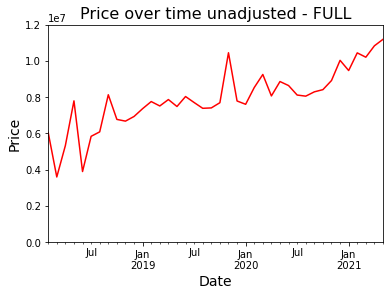

In [18]:
#shows average price over time FULL
Series.plot(color = 'red')
plt.ylabel('Price',fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.title('Price over time unadjusted - FULL', fontsize = 16)
plt.ylim(0, 12000000)
plt.show()

Adjusted price over time with full data

<ipython-input-19-1328da37be0a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ADJPRCFL['Month'] = ADJPRCFL['date'].dt.to_period('M')


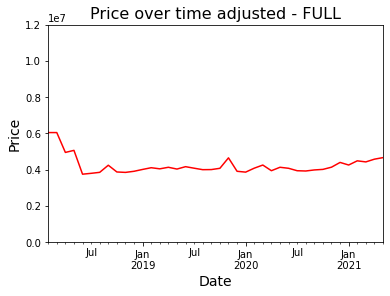

In [19]:
#average price over time full - ADJUSTED
ADJPRCFL = DATA[["ADJ_Price","date"]] 
ADJPRCFL['Month'] = ADJPRCFL['date'].dt.to_period('M') 
FULL_GraphADJ = ADJPRCFL.groupby('Month')['ADJ_Price'].mean()

FULL_GraphADJ.plot(color = 'red')
plt.ylabel('Price',fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.title('Price over time adjusted - FULL', fontsize = 16)
plt.ylim(0, 12000000)
plt.show()